# PART3 パラメータをチューニングしてみよう

## おまじない

In [54]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import pydotplus
from IPython.display import Image

## データの読み込み
- train.csvとtest.csvとsubmit_sample.csvの３つのファイルを読み込みましょう
- それぞれを読み込んだものは変数はtrain, test, sampleに代入しましょう

In [38]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("submit_sample.csv", header = None)

## trainから説明変数となるデータを取り出しましょう
- iloc[]を使います
- y以外を説明変数として取り出し、変数trainXに代入しましょう

In [39]:
trainX = train.iloc[: , 0:17]

In [40]:
trainX

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,939,1,-1,0,unknown
1,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,172,10,-1,0,unknown
2,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,567,1,595,2,failure
3,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,423,1,-1,0,unknown
4,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,502,1,9,2,success
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27123,27124,42,blue-collar,married,primary,no,1455,yes,no,cellular,2,feb,279,2,269,2,other
27124,27125,34,services,single,secondary,no,719,yes,no,unknown,15,may,362,3,-1,0,unknown
27125,27126,36,blue-collar,single,primary,no,49,yes,no,unknown,8,may,405,1,-1,0,unknown
27126,27127,33,housemaid,married,primary,no,209,no,no,cellular,12,aug,76,4,-1,0,unknown


## trainから目的変数となるデータを取り出しましょう
- yを選択し、変数yに代入しましょう

In [41]:
y = train["y"]

## testから説明変数となるデータを取り出しましょう
- testの全てのカラムが説明変数となりますので、copy関数を使って変数testXに代入します

In [42]:
testX = test.copy()

## trainXとtestXをダミー変数化しましょう

In [43]:
trainX = pd.get_dummies(trainX)
testX = pd.get_dummies(testX)

## 決定木モデルの箱を用意しましょう
- 変数名をclf1とし、DT()を代入しましょう
- パラメータは一旦、max_depth=2, min_samples_leaf=500としましょう

In [44]:
clf1 = DT(max_depth=2, min_samples_leaf=500)

## クロスバリデーションをしてclf1の精度を確かめてみましょう
- cross_validate関数を使います
- オプションには、clf1, trainX, y, cv=5, scoring="roc_auc",n_jobs=-1と書きます
- return_train_score=True　追記

In [45]:
cross_validate(clf1, trainX, y, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)

{'fit_time': array([0.06552887, 0.07240915, 0.07463503, 0.06605601, 0.0736959 ]),
 'score_time': array([0.004565  , 0.00673676, 0.00602794, 0.00671411, 0.00797915]),
 'test_score': array([0.74657601, 0.76182968, 0.73117591, 0.73707281, 0.75910043]),
 'train_score': array([0.74534692, 0.74543889, 0.75305367, 0.75162494, 0.746135  ])}

## 異なるパラメータでもう一度決定木の箱を準備しましょう
- 変数はclf2としましょう
- パラメータはmax_depth=10, min_samples_leaf=500としましょう

In [46]:
clf2 = DT(max_depth=10, min_samples_leaf=500)

## クロスバリデーションをしてclf2の精度を確かめてみましょう

In [47]:
cross_validate(clf2, trainX, y, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)

{'fit_time': array([0.13046789, 0.12579489, 0.12477732, 0.12258005, 0.1268301 ]),
 'score_time': array([0.0054729 , 0.00611401, 0.00543571, 0.00621891, 0.00652599]),
 'test_score': array([0.88264002, 0.88482571, 0.86778474, 0.89239853, 0.88343681]),
 'train_score': array([0.88842017, 0.89038512, 0.89288003, 0.8876343 , 0.885615  ])}

## 新たな決定木モデルの箱を準備しましょう
- 変数clf3とし、今回は特にパラメータはセットしません

In [48]:
clf3 = DT()

## グリッドサーチを試してみましょう
- パラメータの範囲を指定し、その範囲をしらみつぶしに調べることで、最適なパラメータを探索することをグリッドサーチといいます
- グリッドサーチ＋クロスバリデーションの組み合わせは良くパラメータ探索の方法として利用されます
- まず探索するパラメータの範囲を表す変数parametersを作ります
- この変数を作る時、"カギ"括弧ではなく、"波"括弧であることに注意して下さい
- {"パラメータの名前①":[範囲], "パラメータの名前②":[範囲]...}のように書きます
- 今回はmax_depthを2から10まで探索してみます

In [50]:
parameters = {"max_depth":[2,3,4,5,6,7,9,10]}

In [51]:
parameters = {"max_depth":list(range(2, 11))}

In [52]:
parameters

{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

## グリッドサーチ+クロスバリデーションで最適なパラメータを探してみましょう

- GridSearchCV関数を使います
- オプションとして、clf3, parameters, cv=5, scoring="roc_auc",n_jobs=-1と書きます
- グリッドサーチの結果は、変数gcvに代入しましょう
- その後、fit関数を使って、探索をしましょう

In [58]:
gcv = GridSearchCV(clf3, parameters, cv=5, scoring="roc_auc",n_jobs=-1, return_train_score=True)
gcv.fit(trainX, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
           

## グリッドサーチの結果を見てみましょう
- cv_____results_で結果を見る事が出来ます

In [59]:
gcv.cv_results_

{'mean_fit_time': array([0.07496099, 0.10895767, 0.10545249, 0.1348866 , 0.14484978,
        0.1705452 , 0.18092899, 0.21076045, 0.20590858]),
 'std_fit_time': array([0.00378754, 0.03260664, 0.00792903, 0.00508249, 0.0118815 ,
        0.01098658, 0.00445866, 0.00370103, 0.01500381]),
 'mean_score_time': array([0.0090004 , 0.00710216, 0.00551543, 0.00777164, 0.00657163,
        0.006041  , 0.00764728, 0.006638  , 0.00549631]),
 'std_score_time': array([0.00208167, 0.00110729, 0.00192528, 0.00286398, 0.00124403,
        0.00085695, 0.00212625, 0.0008604 , 0.00086486]),
 'param_max_depth': masked_array(data=[2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 2},
  {'max_depth': 3},
  {'max_depth': 4},
  {'max_depth': 5},
  {'max_depth': 6},
  {'max_depth': 7},
  {'max_depth': 8},
  {'max_depth': 9},
  {'max_depth': 10}],
 'split0_t

## cv_____results_の中で重要な２つをみてみましょう
- cv_____results_["mean_train_score"]とcv_____results_["mean_test_score"]です
- それぞれ変数train_scoreとtest_scoreに代入しましょう

In [60]:
train_score = gcv.cv_results_["mean_train_score"]
test_score = gcv.cv_results_["mean_test_score"]

In [61]:
train_score

array([0.74831988, 0.8124462 , 0.84413528, 0.85726064, 0.86924573,
       0.88601102, 0.89897976, 0.91020861, 0.92430104])

## train_scoreとtest_scoreを可視化しましょう
- x軸をmax_depth、y軸をaucとしてグラフを描きます
- 何も設定しないとx軸は0からスタートとなり、実際の値とずれてしまうので、調整が必要です
- 調整をする為には、plt.xticks([0,1],[2,3])のように書きます
- 上記のオプションの意味は何もしない時に0のものを2とし、1のものを3とする、という意味になります
- 今回はmax_depthを2～10まで調べたので9点あります

([<matplotlib.axis.XTick at 0x122de5a50>,
 <a list of 9 Text xticklabel objects>)

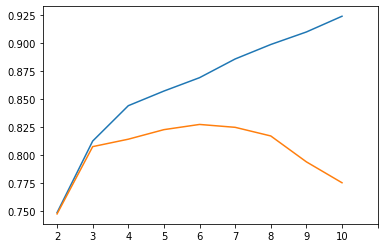

In [64]:
plt.plot(train_score)
plt.plot(test_score)
plt.xticks([0,1,2,3,4,5,6,7,8,9],[2,3,4,5,6,7,8,9,10])

## グリッドサーチで選ばれたパラメータを確認しましょう
- best_____params_で結果を見ることができます

In [65]:
gcv.best_params_

{'max_depth': 6}

## testの予測しましょう
- gcvもpredict_proba関数を持っており、自動的に最適なパラメータを使ったモデルで予測がされます
- 予測結果はpredに代入しましょう。その後、1の確率のみを取り出して、再びpredに代入しましょう

In [66]:
pred = gcv.predict_proba(testX)

In [67]:
pred = pred[: ,1]

## predをsample[1]に代入してファイル出力し、DeepAnalyticsへ投稿しましょう
- ファイル名は「submit3_bank.csv」としましょう
- index=None,header=Noneのオプションを忘れないように書きだしましょう

In [68]:
sample[1] = pred

In [69]:
sample.to_csv("submit_bank.csv", index = None, header = None)

# 実習

1.新たな決定木モデルの箱を変数clf4として準備してみよう。パラメータの設定は不要です

In [76]:
clf4 = DT()

2.max_depthとmin_samples_leafの値の範囲を指定した変数parameters2を作ろう
- max_depthは2～10まで、min_samples_leafは[5,10,20,50,100,500]にしましょう

In [77]:
parameters2 = {"max_depth" : list(range(2,11)), "min_samples_leaf" : [5,10,20,50,100,500]}

3.グリッドサーチ+クロスバリデーションで最適なパラメータを探そう。グリッドサーチの結果は変数gcv2に代入しよう

In [90]:
gcv2 = GridSearchCV(clf4, parameters2, cv=5, scoring="roc_auc",n_jobs=-1, return_train_score=True)
gcv2.fit(trainX, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
            

4.最適なパラメータはなんだったか確かめてみよう

In [91]:
gcv2.best_params_

{'max_depth': 10, 'min_samples_leaf': 50}

5.testの予測をし、予測結果のうち、１となる確率のみを変数pred2に代入しよう

In [92]:
pred2 = gcv2.predict_proba(testX)

In [93]:
pred2 = pred2[:,1]

6.pred2をsample[1]に代入して"submit4_bank.csv"としてファイル出力し、DeepAnalyticsへ投稿しよう

In [94]:
sample[1] = pred2

In [95]:
sample.to_csv("submit4_bank.csv", index = None, header = None)

In [96]:
sample

,0,1
0,1,0.813559
1,2,0.583333
2,3,0.010835
3,4,0.010835
4,5,0.130498
...,...,...
18078,18079,0.010835
18079,18080,0.189655
18080,18081,0.010835
18081,18082,0.010835
